# Importar librerias

In [1]:
# imports time series
import pandas as pd
import numpy as np
import seaborn as sns

# plots
import matplotlib.pyplot as plt
%matplotlib inline

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

from prophet import Prophet
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cargar datos

In [3]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "/content/drive/MyDrive/Colab Notebooks/nuclio_2305_str/data")
DATA_PATH

'/content/drive/MyDrive/Colab Notebooks/nuclio_2305_str/data'

In [4]:
FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

In [5]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

Numpy version 1.23.5
Pandas version 1.5.3
XGBoost version 2.0.0


# Data Understanding

In [6]:
df = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)
df.sample(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
9205,2013-08-31,42_7894,14,42,6,7894,1490.0,4.0
11731,2014-04-30,55_15077,16,55,31,15077,899.0,5.0
9260,2013-12-31,42_2445,14,42,30,2445,599.0,4.0
12320,2013-08-31,57_12134,22,57,30,12134,299.0,7.0
701,2015-05-31,15_7893,2,15,6,7893,2915.0,4.0


Tipo datos del dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [8]:
df['date'] = pd.to_datetime(df['date'],format = '%Y-%m-%d')

Total series temporales:

In [9]:
df['unique_id'].nunique()

426

Fechas min y max

In [10]:
MIN_DATE = df['date'].min()
MAX_DATE = df['date'].max()

In [11]:
print(f'Min date es {MIN_DATE}\nMax date es {MAX_DATE}')

Min date es 2013-01-31 00:00:00
Max date es 2015-10-31 00:00:00


In [12]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  13262 non-null  float64       
 7   monthly_sales          13756 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


Data Imputation

In [14]:
sample_ts = "31_4249"

In [15]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [16]:
df['unique_id'].unique()

array(['12_11365', '12_11369', '12_11370', '12_11373', '12_12231',
       '12_482', '12_839', '14_20949', '14_4244', '14_5821', '14_5822',
       '14_5823', '14_7856', '15_20949', '15_2252', '15_2308', '15_2808',
       '15_5821', '15_5822', '15_5823', '15_7893', '15_7894', '16_16227',
       '16_17717', '16_20949', '16_2308', '16_3077', '16_5643', '16_5821',
       '16_5822', '16_5823', '16_7893', '16_7894', '18_17717', '18_2308',
       '18_5820', '18_5821', '18_5822', '18_5823', '18_7856', '19_1523',
       '19_17717', '19_1905', '19_20949', '19_2252', '19_2308', '19_2445',
       '19_5643', '19_5821', '19_5822', '19_5823', '19_6185', '19_7856',
       '19_7894', '21_13881', '21_16169', '21_16227', '21_20949',
       '21_5821', '21_5822', '21_5823', '21_7894', '22_12232', '22_13100',
       '22_13370', '22_17717', '22_18016', '22_19331', '22_19338',
       '22_20949', '22_464', '22_482', '22_491', '22_5822', '22_5823',
       '22_784', '22_839', '22_8555', '24_1905', '24_20949', '24

In [17]:
df_ts_314249 = df[df["unique_id"] == '31_4249']

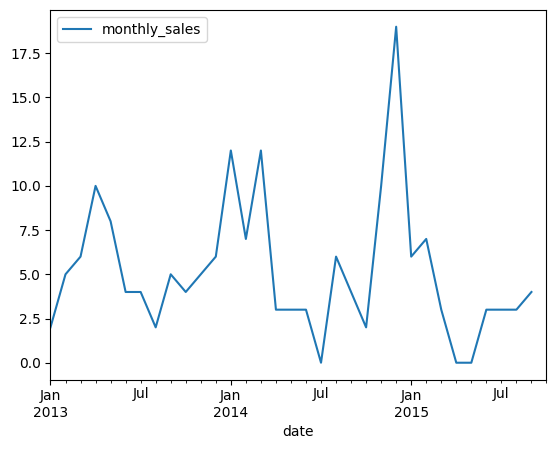

In [18]:
df_ts_314249_ = df_ts_314249[['date','monthly_sales']]
df_ts_314249_.set_index('date').plot();

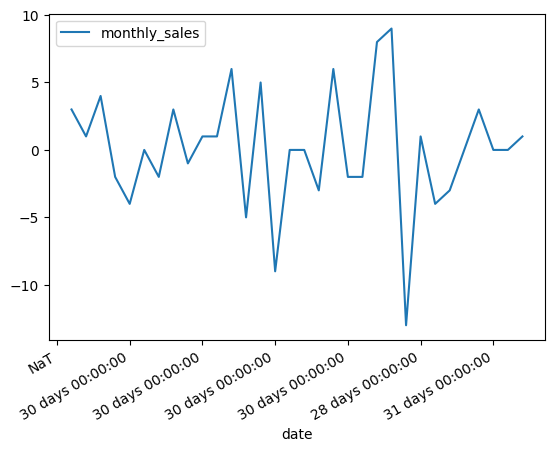

In [19]:
df_ts_314249_.diff().set_index('date').plot();

In [20]:
df_ts_7_5822 = df[df["unique_id"] == '7_5822']

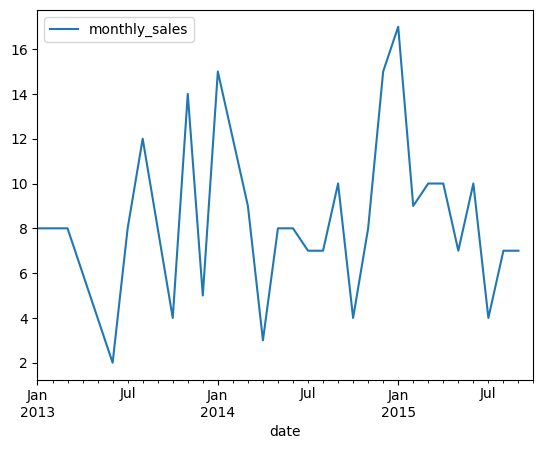

In [21]:
df_ts_7_5822 = df_ts_7_5822[['date','monthly_sales']]
df_ts_7_5822.set_index('date').plot();

# Null Imputation

In [22]:
df['monthly_sales'].fillna(0,inplace=True)

In [23]:
df['monthly_average_price'] = df.groupby(['unique_id'], group_keys=False)['monthly_average_price'].apply(
    lambda series: series.bfill().ffill()
)


In [24]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [25]:
df.sort_values(['unique_id','date'], ascending = True, inplace=True)

In [26]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


# EDA

In [27]:
def plot_ts_acf_pacf(y,title):

  fig = plt.figure(figsize = (12,10))
  ax1,ax2,ax3 = fig.subplots(3,1)

  ax1.plot(y)
  plot_acf(x=y,ax =ax2, lags = 14)
  plot_pacf(x=y,ax =ax3, lags = 14)

  plt.suptitle(t=title,fontsize=20)

In [28]:
df_final = df.copy()

In [29]:
df_final

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
...,...,...,...,...,...,...,...,...
14435,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0
14447,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0
14459,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0
14471,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0


In [30]:
y = df.set_index('date').resample('M')['monthly_sales'].sum()[:-1]

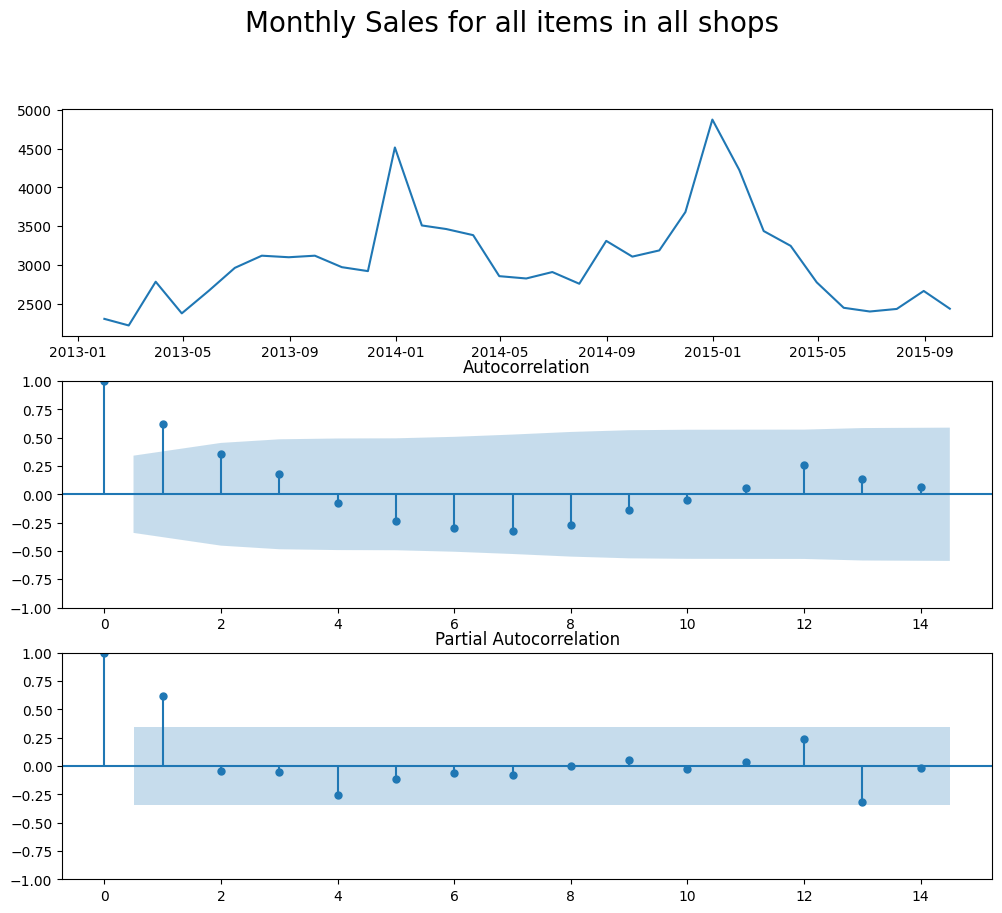

In [31]:
plot_ts_acf_pacf(y=y,title ="Monthly Sales for all items in all shops" );

## City

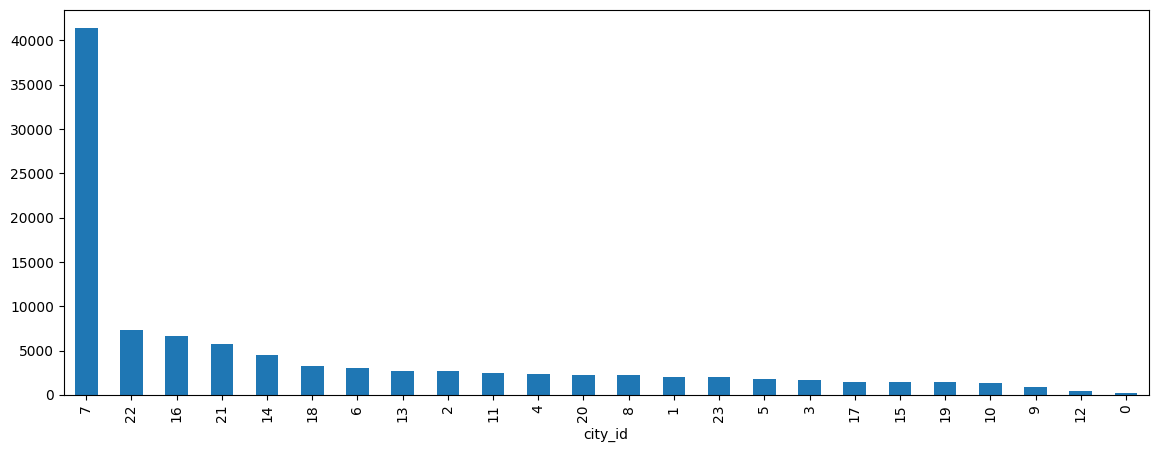

In [32]:
(
    df.groupby(['city_id'])
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);


In [33]:
city_top = (
    df.groupby(['city_id'])
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
    .to_frame()
    .head(1)
    .reset_index()
 )

In [34]:
id_city_ventas = city_top.iloc[0,1]
id_city_top = city_top.iloc[0,0]

In [35]:
print(f'La id de la ciudad con más ventas es {id_city_top} con {id_city_ventas} ventas')

La id de la ciudad con más ventas es 7 con 41360.0 ventas


## Categories

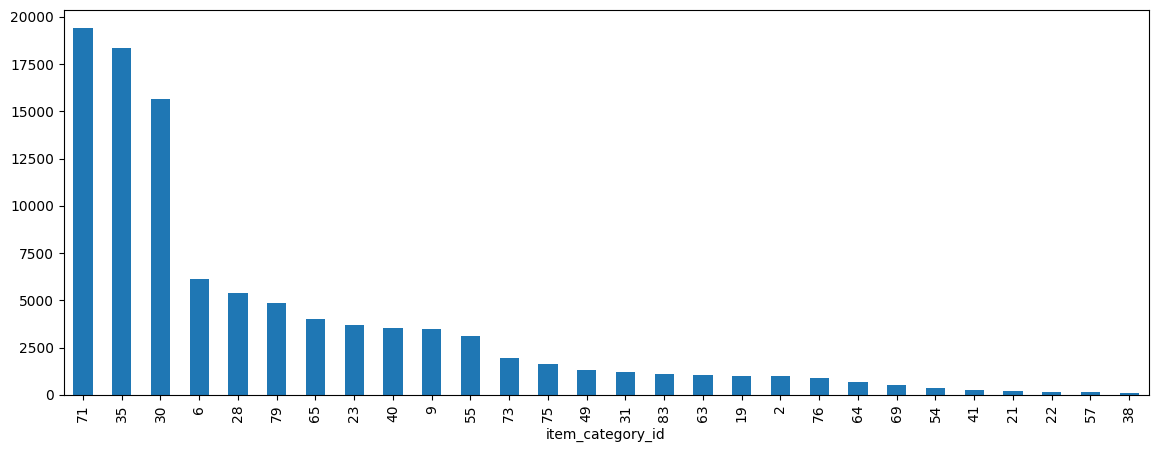

In [36]:
(
    df.groupby(['item_category_id'])
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);

In [37]:
category_top = (
    df.groupby(['item_category_id'])
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
    .to_frame()
    .head(1)
    .reset_index()
 )

In [38]:
id_category_ventas = category_top.iloc[0,1]
id_category_top = category_top.iloc[0,0]

In [39]:
print(f'La id de la categoria con más ventas es {id_category_top} con {id_category_ventas} ventas')

La id de la categoria con más ventas es 71 con 19400.0 ventas


 ### Categoria con MÁS INGRESOS mes SEPTIEMBRE

In [40]:
df['revenue']= df['monthly_average_price']*df['monthly_sales']

<Axes: xlabel='item_category_id'>

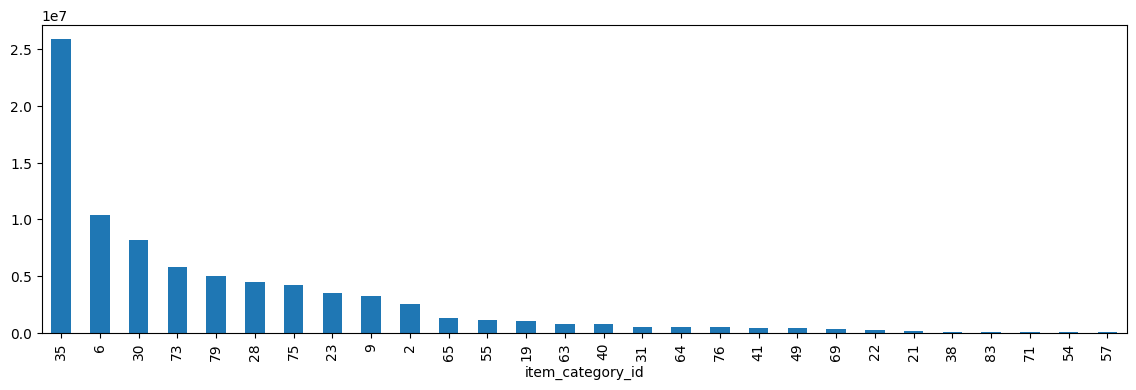

In [41]:
(
    df
    .groupby(['item_category_id'])
    ['revenue'].sum()
    .sort_values(ascending = False)
    .plot(kind = 'bar',figsize = (14,4))
)

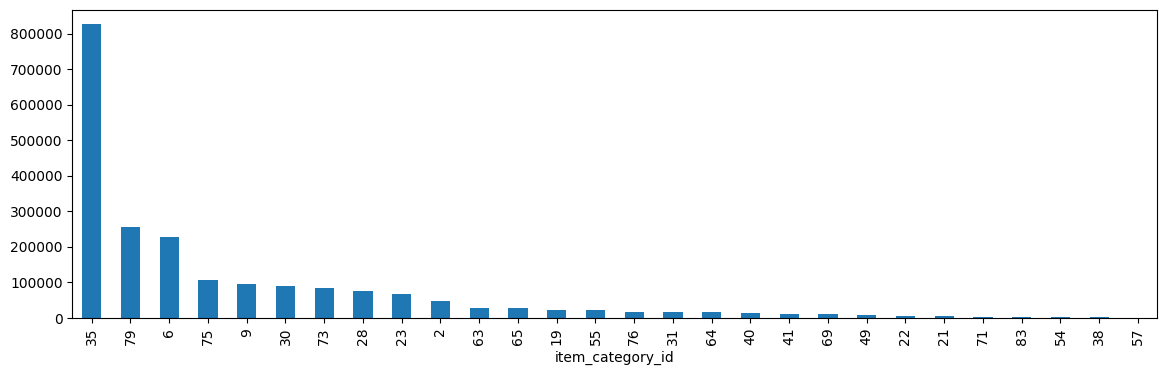

In [42]:
df_septiembre = df[df['date']=='2015-09-30']

(
    df_septiembre
    .groupby(['item_category_id'])
    ['revenue'].sum()
    .sort_values(ascending = False)
    .plot(kind = 'bar',figsize = (14,4))
);



In [43]:
top_ingresos_septiembre=(
   df_septiembre
    .groupby(['item_category_id'])
    ['revenue'].sum().round(2)
    .sort_values(ascending = False)
    .head(1)
    .to_frame()
    .reset_index()
)

In [44]:
numero_ventas = top_ingresos_septiembre.iloc[0,1]
item_category_id_top = top_ingresos_septiembre.iloc[0,0]

In [45]:
print(f'El item_category_id con más ingresos en el mes de Septiembre de 2015 es {item_category_id_top} con {numero_ventas} nº de ventas')

El item_category_id con más ingresos en el mes de Septiembre de 2015 es 35 con 825643.73 nº de ventas


 ## Item

### Item con mayores ingresos

<Axes: xlabel='item_id'>

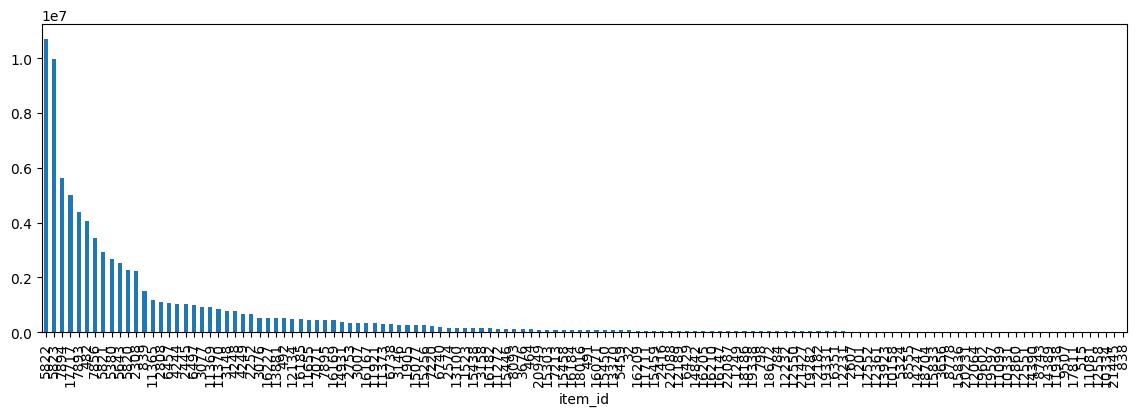

In [46]:
(
    df
    .groupby(['item_id'])
    ['revenue'].sum()
    .sort_values(ascending = False)
    .plot(kind = 'bar',figsize = (14,4))
)

### ID categoria con MAYOR nº de ITEM_ID diferentes

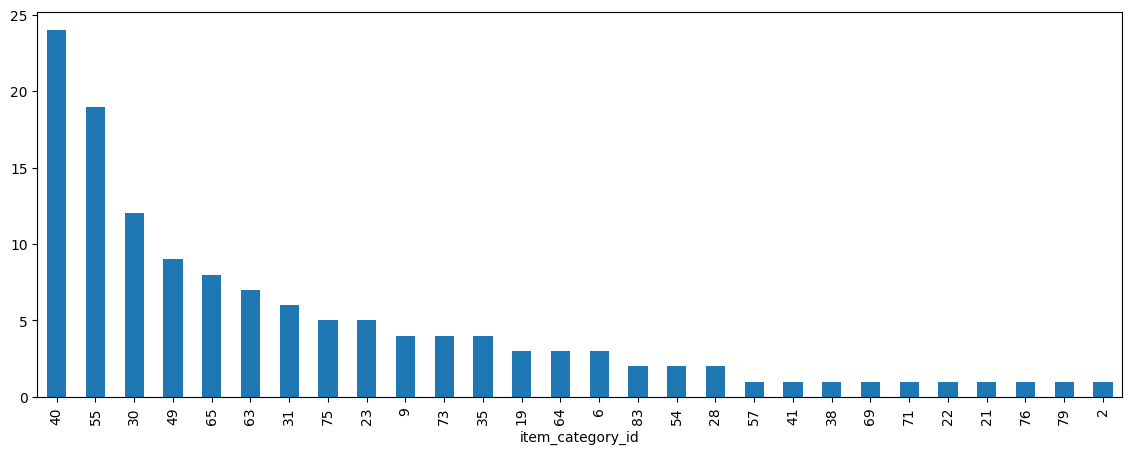

In [47]:
(
    df.groupby(['item_category_id'])
    ['item_id'].nunique()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);

In [48]:
items_diferentes = df[df['item_category_id']==40]['item_id'].nunique()

print(f'El item_category_id con más productos diferentes es el nº 40 con {items_diferentes} item_id diferentes')

El item_category_id con más productos diferentes es el nº 40 con 24 item_id diferentes


 ## Shop con MÁS INGRESOS

<Axes: xlabel='shop_id'>

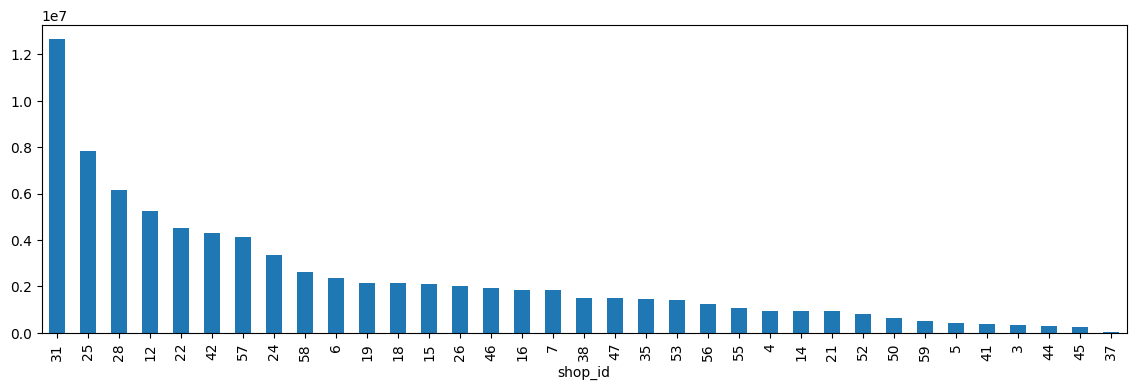

In [49]:
(
    df
    .groupby(['shop_id'])
    ['revenue'].sum()
    .sort_values(ascending = False)
    .plot(kind = 'bar',figsize = (14,4))
)

In [50]:
df[df['date']=='2015-09-30'].sort_values(by = 'revenue', ascending = False)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue
9601,2015-09-30,42_5823,14,42,35,5823,2799.000000,18.0,50382.000000
4340,2015-09-30,25_5823,7,25,35,5823,2799.000000,16.0,44784.000000
225,2015-09-30,12_11369,16,12,9,11369,1321.367605,30.0,39641.028139
8109,2015-09-30,31_17717,7,31,79,17717,1236.392419,30.0,37091.772575
4614,2015-09-30,26_5823,7,26,35,5823,2799.000000,12.0,33588.000000
...,...,...,...,...,...,...,...,...,...
8116,2015-09-30,31_21445,7,31,40,21445,99.000000,1.0,99.000000
8091,2015-09-30,31_12860,7,31,40,12860,99.000000,1.0,99.000000
13586,2015-09-30,59_20949,23,59,71,20949,5.000000,18.0,90.000000
9888,2015-09-30,45_20949,13,45,71,20949,5.000000,15.0,75.000000


## Meses con más ventas

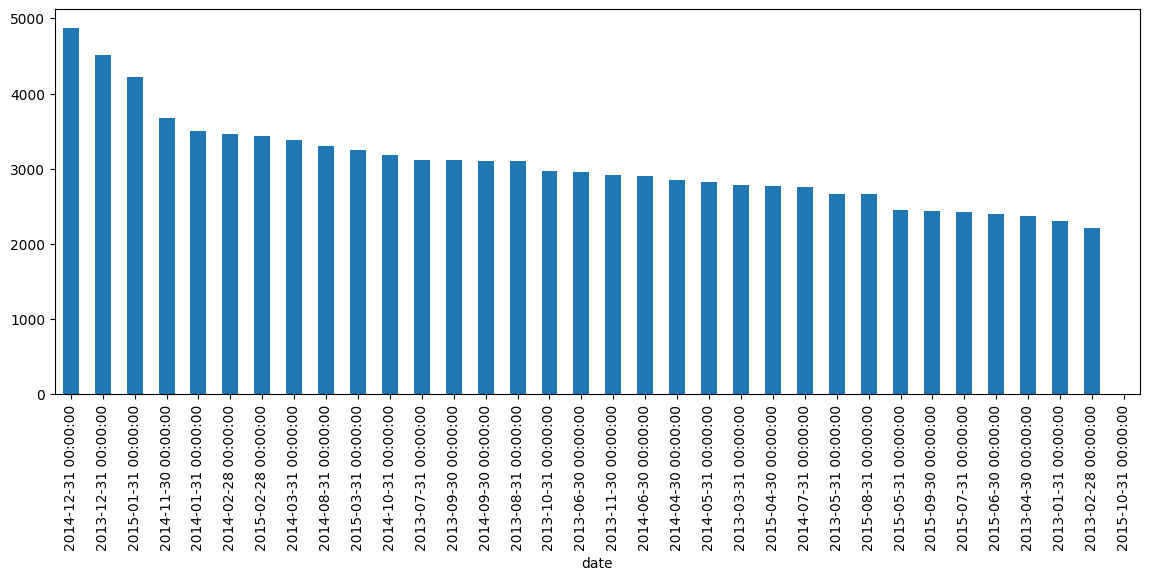

In [51]:
(
    df.groupby(['date'])
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);

In [52]:
mes_mayores_ventas = df[df['date']=='2014-12-31']['monthly_sales'].sum()

print(f'El mes de Diciembre del año 2014 obtuvo mayores ventas con un total de {mes_mayores_ventas} ventas')

El mes de Diciembre del año 2014 obtuvo mayores ventas con un total de 4874.0 ventas


## Media móvil de 3 meses (de todas las ventas)

In [53]:
df_3m =(
    df.
    set_index('date')
    .resample('M')
    ['monthly_sales'].sum()[:-1]
    .to_frame()
    .reset_index()
)

df_3m['media_movil_3m'] = df_3m['monthly_sales'].transform(
      lambda series: series.rolling(window = 3).mean()
)

df_3m

,date,monthly_sales,media_movil_3m
0,2013-01-31,2303.0,NaN
1,2013-02-28,2218.0,NaN
2,2013-03-31,2782.0,2434.333333
3,2013-04-30,2374.0,2458.000000
4,2013-05-31,2665.0,2607.000000
5,2013-06-30,2961.0,2666.666667
6,2013-07-31,3118.0,2914.666667
7,2013-08-31,3098.0,3059.000000
8,2013-09-30,3118.0,3111.333333
9,2013-10-31,2970.0,3062.000000


In [54]:
media_movil_3_meses = df_3m['media_movil_3m'].iloc[2]
fecha_media_movil_3_meses = df_3m['date'].iloc[2]

In [55]:
print(f'La media móvil de 3 meses corresponde a la fecha  {fecha_media_movil_3_meses} con un valor de {media_movil_3_meses}')

La media móvil de 3 meses corresponde a la fecha  2013-03-31 00:00:00 con un valor de 2434.3333333333335


## Exploración others

In [56]:
df['year'] = df['date'].dt.year

In [57]:
df['month'] = df['date'].dt.month

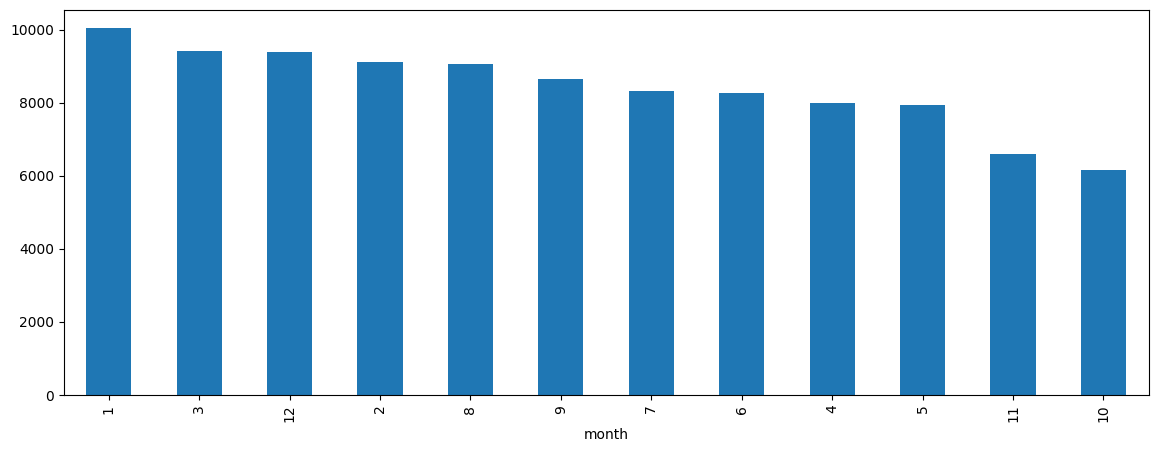

In [58]:
(
    df.
    groupby(['month'])
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);

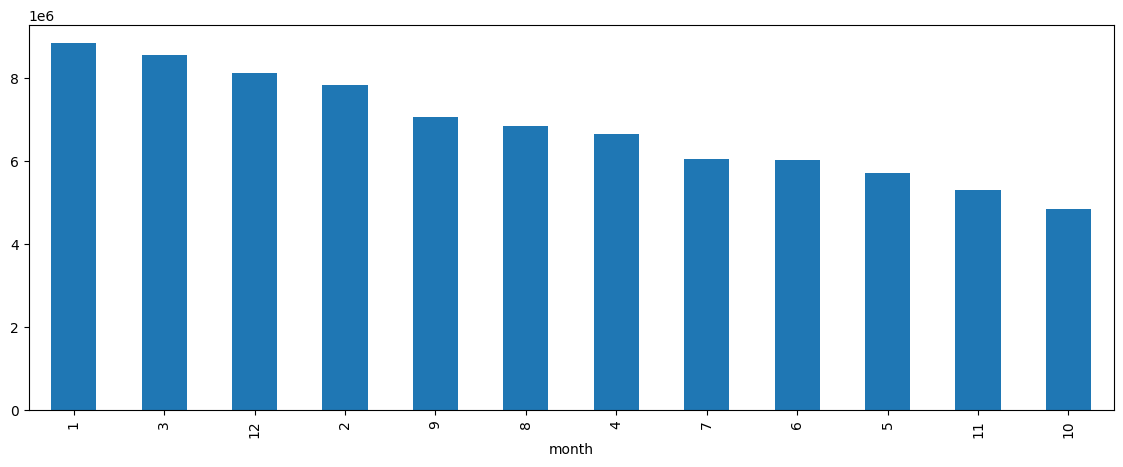

In [59]:
(
    df.
    groupby(['month'])
    ['revenue'].sum()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);

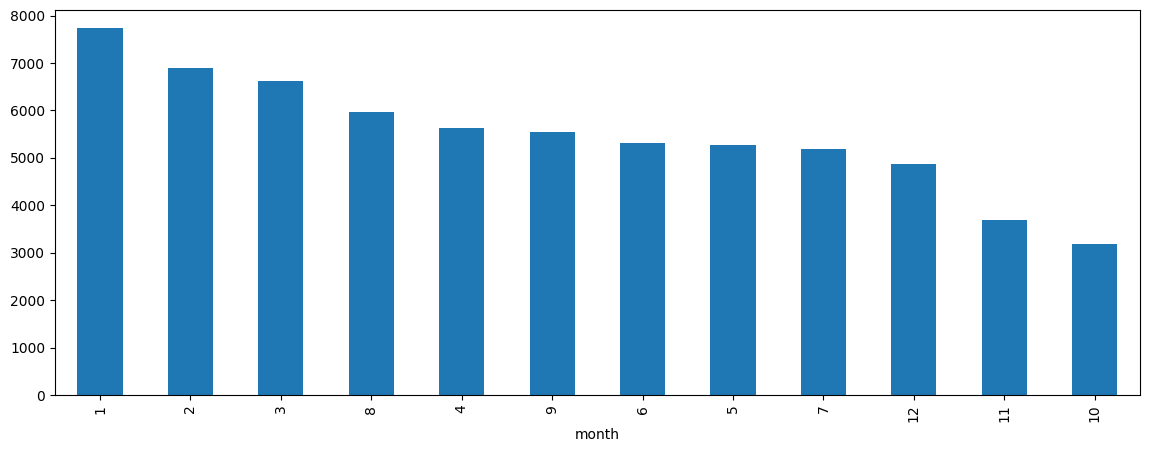

In [60]:
(
    df[df['year']!=2013]
    .groupby('month')
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);

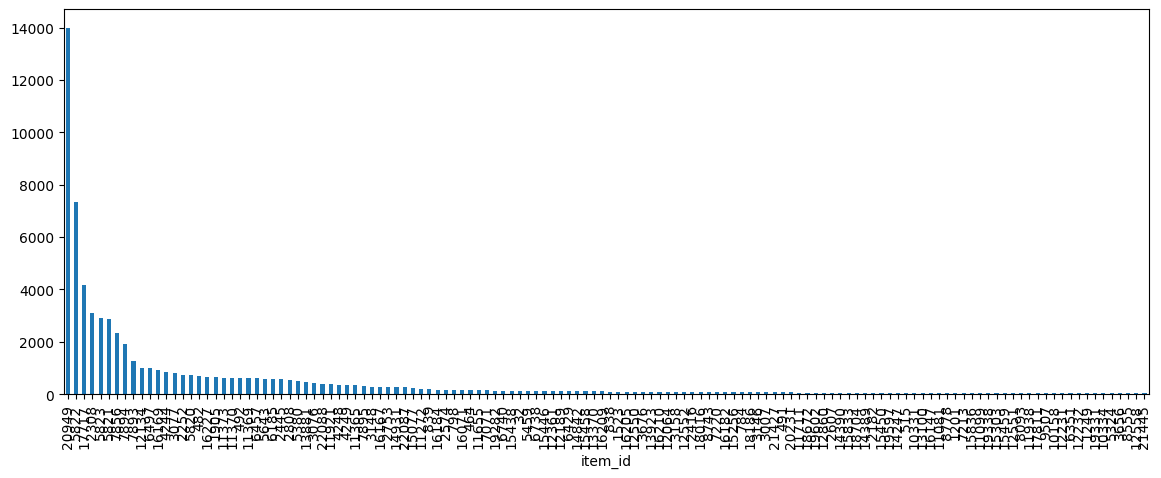

In [61]:
(
    df[df['year']!=2013]
    .groupby('item_id')
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);

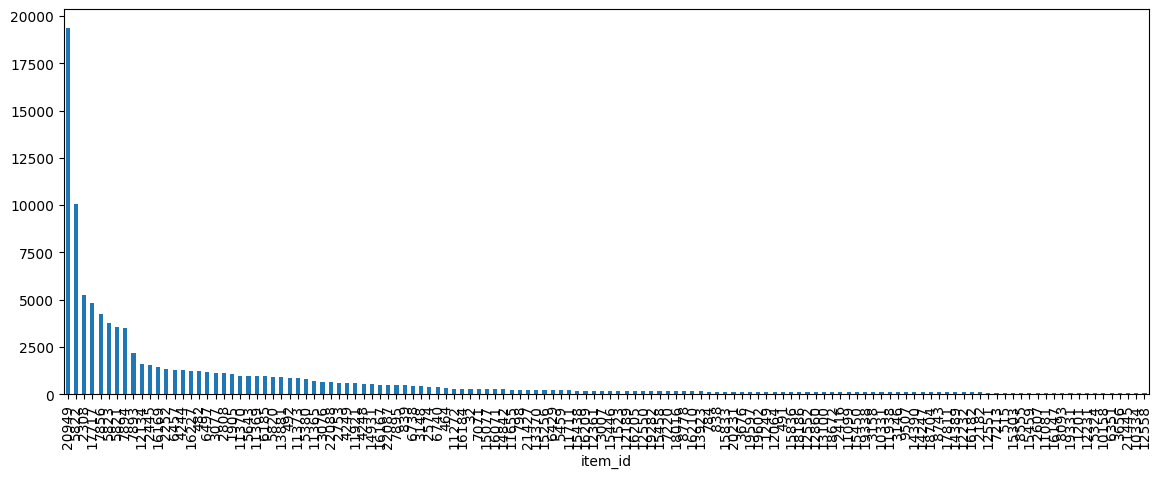

In [62]:
(
    df
    .groupby('item_id')
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);

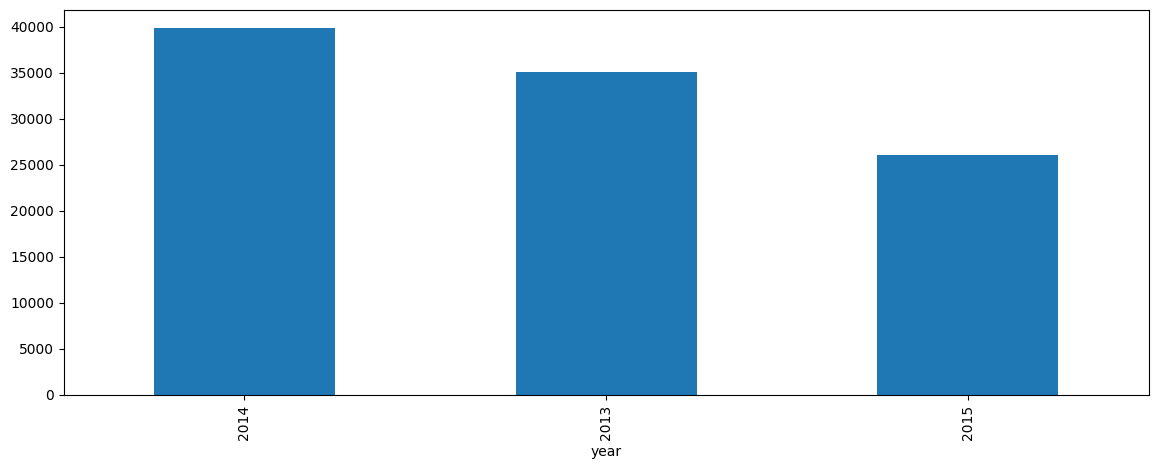

In [63]:
(
    df.
    groupby(['year'])
    ['monthly_sales'].sum()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);

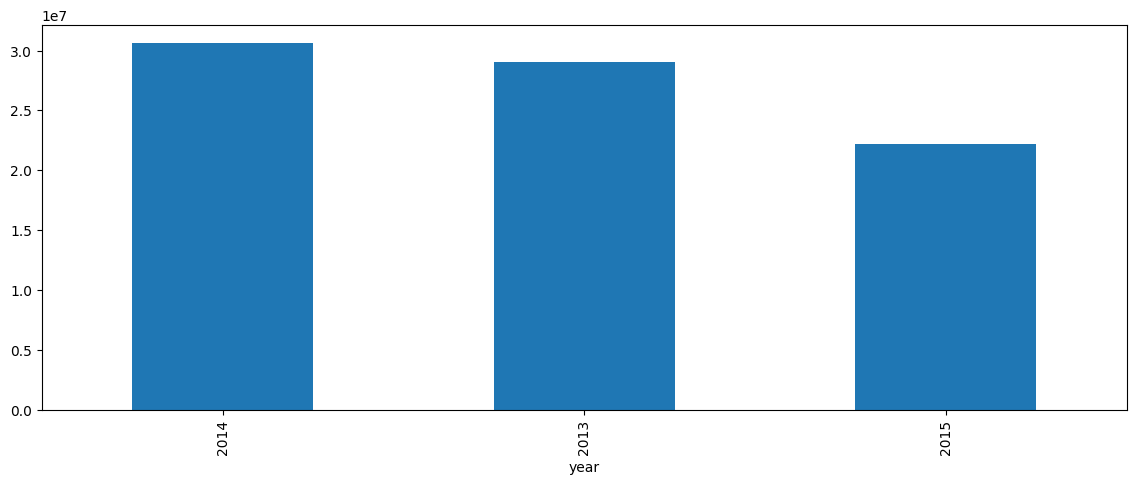

In [64]:
(
    df.
    groupby(['year'])
    ['revenue'].sum()
    .sort_values(ascending = False)
    .plot(kind='bar',figsize=(14,5))
);

In [65]:
df['month'].value_counts()

1     1278
2     1278
3     1278
4     1278
5     1278
6     1278
7     1278
8     1278
9     1278
10    1278
11     852
12     852
Name: month, dtype: int64

In [66]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,year,month
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,2013,1
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,2013,2
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,2013,3
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,2013,4
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,2013,5
...,...,...,...,...,...,...,...,...,...,...,...
14435,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0,2490.000000,2015,6
14447,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0,2690.000000,2015,7
14459,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0,2490.000000,2015,8
14471,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0,13449.500000,2015,9


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  14484 non-null  float64       
 7   monthly_sales          14484 non-null  float64       
 8   revenue                14484 non-null  float64       
 9   year                   14484 non-null  int64         
 10  month                  14484 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(1)
memory usage: 1.3+ MB


In [68]:
df.describe(exclude = np.number).T

,count,unique,top,freq,first,last
date,14484,34,2013-01-31 00:00:00,426,2013-01-31,2015-10-31
unique_id,14484,426,12_11365,34,NaT,NaT


In [69]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
city_id,14484.0,10.833333,6.227364,0.000000,7.0,7.0,16.0,23.000000
shop_id,14484.0,31.967136,15.236351,3.000000,22.0,31.0,44.0,59.000000
item_category_id,14484.0,39.356808,20.439654,2.000000,30.0,35.0,55.0,83.000000
item_id,14484.0,8626.431925,5905.273346,32.000000,4248.0,6457.0,12551.0,22088.000000
monthly_average_price,14484.0,914.120568,823.684921,4.928571,299.0,649.0,1149.0,9305.121212
monthly_sales,14484.0,6.969069,7.878401,0.000000,2.0,4.0,8.0,30.000000
revenue,14484.0,5653.074846,9100.162292,0.000000,599.0,2392.0,6790.5,223322.909091
year,14484.0,2013.941176,0.802274,2013.000000,2013.0,2014.0,2015.0,2015.000000
month,14484.0,6.205882,3.323644,1.000000,3.0,6.0,9.0,12.000000


In [70]:
TARGET = 'monthly_sales'
describe_df_target = df[TARGET].describe()
describe_df_target

count    14484.000000
mean         6.969069
std          7.878401
min          0.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: monthly_sales, dtype: float64

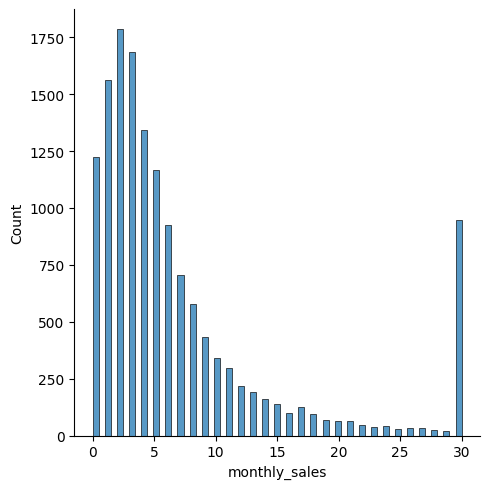

In [71]:
sns.displot(df[TARGET]);

# .diff()

In [72]:
# df['monthly_sales'] = df.groupby(['unique_id'], group_keys=False)['monthly_sales'].apply(
#     lambda series: series.diff()
# )

# REFACTOR para construcción variables

In [73]:
def build_ts_vars(df,gb_list,target_column,agg_func,agg_func_name):

  assert 'date' in df.columns.tolist(), 'Date must be in df columns'
  assert isinstance(gb_list,list), 'Error, must be a list'

  new_name = '_'.join(gb_list+[target_column]+ [agg_func_name])

  gb_df = (
      df
      .set_index('date')
      .groupby(gb_list)
      .resample('M')[target_column]
      .apply(agg_func)
      .to_frame()
      .reset_index()
      .rename(
          columns = {
              target_column:new_name
          }
      )

  )

    ### lags

  gb_df[f'{new_name}_lag1'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(1)
  )

  gb_df[f'{new_name}_lag12'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(12)
  )
  gb_df[f'{new_name}_lag13'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(13)
  )


    ### media móvil

  gb_df[f'{new_name}_m1'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(1).rolling(window = 3).mean()
  )
  gb_df[f'{new_name}_m2'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(2).rolling(window = 3).mean()
  )
  gb_df[f'{new_name}_m3'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(3).rolling(window = 3).mean()
  )
  gb_df[f'{new_name}_m4'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(4).rolling(window = 3).mean()
  )
  gb_df[f'{new_name}_m10'] = gb_df.groupby(gb_list)[new_name].transform(
      lambda series: series.shift(10).rolling(window = 3).mean()
  )


  print(f'Dropping columns that might cause target leakage')
  gb_df.drop(new_name, inplace = True, axis=1)


  return gb_df

In [74]:
df.head(1)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,year,month
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,2013,1


In [75]:
GB_LIST_1 = ['unique_id']
TARGET_COLUMN_1 = 'monthly_sales'
AGG_FUNC_1 = np.sum
AGG_FUNC_NAME_1 = 'sum'

vars_ts_1= build_ts_vars(
df = df,
gb_list = GB_LIST_1,
target_column = TARGET_COLUMN_1,
agg_func = AGG_FUNC_1,
agg_func_name = AGG_FUNC_NAME_1,
)
vars_ts_1.head(10)

Dropping columns that might cause target leakage


,unique_id,date,unique_id_monthly_sales_sum_lag1,unique_id_monthly_sales_sum_lag12,unique_id_monthly_sales_sum_lag13,unique_id_monthly_sales_sum_m1,unique_id_monthly_sales_sum_m2,unique_id_monthly_sales_sum_m3,unique_id_monthly_sales_sum_m4,unique_id_monthly_sales_sum_m10
0,12_11365,2013-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12_11365,2013-02-28,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12_11365,2013-03-31,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12_11365,2013-04-30,30.0,NaN,NaN,29.000000,NaN,NaN,NaN,NaN
4,12_11365,2013-05-31,27.0,NaN,NaN,28.000000,29.000000,NaN,NaN,NaN
5,12_11365,2013-06-30,30.0,NaN,NaN,29.000000,28.000000,29.000000,NaN,NaN
6,12_11365,2013-07-31,28.0,NaN,NaN,28.333333,29.000000,28.000000,29.000000,NaN
7,12_11365,2013-08-31,20.0,NaN,NaN,26.000000,28.333333,29.000000,28.000000,NaN
8,12_11365,2013-09-30,16.0,NaN,NaN,21.333333,26.000000,28.333333,29.000000,NaN
9,12_11365,2013-10-31,24.0,NaN,NaN,20.000000,21.333333,26.000000,28.333333,NaN


In [76]:
GB_LIST_2 = ['unique_id']
TARGET_COLUMN_2 = 'monthly_average_price'
AGG_FUNC_2 = np.sum
AGG_FUNC_NAME_2 = 'sum'

vars_ts_2= build_ts_vars(
df = df,
gb_list = GB_LIST_2,
target_column = TARGET_COLUMN_2,
agg_func = AGG_FUNC_2,
agg_func_name = AGG_FUNC_NAME_2,
)
vars_ts_2.head(10)

Dropping columns that might cause target leakage


,unique_id,date,unique_id_monthly_average_price_sum_lag1,unique_id_monthly_average_price_sum_lag12,unique_id_monthly_average_price_sum_lag13,unique_id_monthly_average_price_sum_m1,unique_id_monthly_average_price_sum_m2,unique_id_monthly_average_price_sum_m3,unique_id_monthly_average_price_sum_m4,unique_id_monthly_average_price_sum_m10
0,12_11365,2013-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12_11365,2013-02-28,1511.512626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12_11365,2013-03-31,1533.125000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12_11365,2013-04-30,3252.470238,NaN,NaN,2099.035955,NaN,NaN,NaN,NaN
4,12_11365,2013-05-31,1590.515152,NaN,NaN,2125.370130,2099.035955,NaN,NaN,NaN
5,12_11365,2013-06-30,1447.531250,NaN,NaN,2096.838880,2125.370130,2099.035955,NaN,NaN
6,12_11365,2013-07-31,1302.343750,NaN,NaN,1446.796717,2096.838880,2125.370130,2099.035955,NaN
7,12_11365,2013-08-31,1736.785714,NaN,NaN,1495.553571,1446.796717,2096.838880,2125.370130,NaN
8,12_11365,2013-09-30,3072.361111,NaN,NaN,2037.163525,1495.553571,1446.796717,2096.838880,NaN
9,12_11365,2013-10-31,9305.121212,NaN,NaN,4704.756013,2037.163525,1495.553571,1446.796717,NaN


In [77]:
GB_LIST_3 = ['unique_id']
TARGET_COLUMN_3 = 'revenue'
AGG_FUNC_3 = np.mean
AGG_FUNC_NAME_3 = 'mean'

vars_ts_3= build_ts_vars(
df = df,
gb_list = GB_LIST_3,
target_column = TARGET_COLUMN_3,
agg_func = AGG_FUNC_3,
agg_func_name = AGG_FUNC_NAME_3,
)
vars_ts_3.head(10)


Dropping columns that might cause target leakage


,unique_id,date,unique_id_revenue_mean_lag1,unique_id_revenue_mean_lag12,unique_id_revenue_mean_lag13,unique_id_revenue_mean_m1,unique_id_revenue_mean_m2,unique_id_revenue_mean_m3,unique_id_revenue_mean_m4,unique_id_revenue_mean_m10
0,12_11365,2013-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12_11365,2013-02-28,45345.378788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12_11365,2013-03-31,41394.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12_11365,2013-04-30,97574.107143,NaN,NaN,61437.953644,NaN,NaN,NaN,NaN
4,12_11365,2013-05-31,42943.909091,NaN,NaN,60637.463745,61437.953644,NaN,NaN,NaN
5,12_11365,2013-06-30,43425.937500,NaN,NaN,61314.651245,60637.463745,61437.953644,NaN,NaN
6,12_11365,2013-07-31,36465.625000,NaN,NaN,40945.157197,61314.651245,60637.463745,61437.953644,NaN
7,12_11365,2013-08-31,34735.714286,NaN,NaN,38209.092262,40945.157197,61314.651245,60637.463745,NaN
8,12_11365,2013-09-30,49157.777778,NaN,NaN,40119.705688,38209.092262,40945.157197,61314.651245,NaN
9,12_11365,2013-10-31,223322.909091,NaN,NaN,102405.467051,40119.705688,38209.092262,40945.157197,NaN


## Join full_df con variables auxiliares

In [78]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,year,month
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,2013,1
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,2013,2
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,2013,3
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,2013,4
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,2013,5


In [79]:
print(df.shape)

df = pd.merge(df,vars_ts_1, on = ['date'] + GB_LIST_1, how = 'left')

print(df.shape)

(14484, 11)
(14484, 19)


In [80]:
print(df.shape)

df = pd.merge(df, vars_ts_2, on = ['date'] + GB_LIST_2, how = 'left')

print(df.shape)

(14484, 19)
(14484, 27)


In [81]:
print(df.shape)

df = pd.merge(df, vars_ts_3, on = ['date'] + GB_LIST_3, how = 'left')

print(df.shape)

(14484, 27)
(14484, 35)


In [82]:
df.head(3)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,year,...,unique_id_monthly_average_price_sum_m4,unique_id_monthly_average_price_sum_m10,unique_id_revenue_mean_lag1,unique_id_revenue_mean_lag12,unique_id_revenue_mean_lag13,unique_id_revenue_mean_m1,unique_id_revenue_mean_m2,unique_id_revenue_mean_m3,unique_id_revenue_mean_m4,unique_id_revenue_mean_m10
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,2013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,2013,...,NaN,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,2013,...,NaN,NaN,41394.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
df[(df['unique_id'] =='44_20949') & (df['month'] ==9)]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,year,...,unique_id_monthly_average_price_sum_m4,unique_id_monthly_average_price_sum_m10,unique_id_revenue_mean_lag1,unique_id_revenue_mean_lag12,unique_id_revenue_mean_lag13,unique_id_revenue_mean_m1,unique_id_revenue_mean_m2,unique_id_revenue_mean_m3,unique_id_revenue_mean_m4,unique_id_revenue_mean_m10
9664,2013-09-30,44_20949,13,44,71,20949,5.0,30.0,150.0,2013,...,5.0,NaN,150.0,NaN,NaN,149.807692,133.141026,83.333333,33.333333,NaN
9676,2014-09-30,44_20949,13,44,71,20949,5.0,21.0,105.0,2014,...,5.0,5.0,150.0,150.0,150.0,148.333333,145.000000,146.666667,146.666667,150.000000
9688,2015-09-30,44_20949,13,44,71,20949,5.0,3.0,15.0,2015,...,5.0,5.0,15.0,105.0,150.0,30.000000,58.333333,75.000000,103.333333,121.666667


Train Test Split

In [84]:
df.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'revenue',
 'year',
 'month',
 'unique_id_monthly_sales_sum_lag1',
 'unique_id_monthly_sales_sum_lag12',
 'unique_id_monthly_sales_sum_lag13',
 'unique_id_monthly_sales_sum_m1',
 'unique_id_monthly_sales_sum_m2',
 'unique_id_monthly_sales_sum_m3',
 'unique_id_monthly_sales_sum_m4',
 'unique_id_monthly_sales_sum_m10',
 'unique_id_monthly_average_price_sum_lag1',
 'unique_id_monthly_average_price_sum_lag12',
 'unique_id_monthly_average_price_sum_lag13',
 'unique_id_monthly_average_price_sum_m1',
 'unique_id_monthly_average_price_sum_m2',
 'unique_id_monthly_average_price_sum_m3',
 'unique_id_monthly_average_price_sum_m4',
 'unique_id_monthly_average_price_sum_m10',
 'unique_id_revenue_mean_lag1',
 'unique_id_revenue_mean_lag12',
 'unique_id_revenue_mean_lag13',
 'unique_id_revenue_mean_m1',
 'unique_id_revenue_mean_m2',
 'unique_id_revenue_mean_m3',
 'unique_id_rev

# Drop columns

In [85]:
COLUMNS_TO_DROP = [
    'revenue',

]
df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [86]:
df.set_index('unique_id',inplace=True)

In [87]:
df.head(5).T

unique_id,12_11365,12_11365,12_11365,12_11365,12_11365
date,2013-01-31 00:00:00,2013-02-28 00:00:00,2013-03-31 00:00:00,2013-04-30 00:00:00,2013-05-31 00:00:00
city_id,16,16,16,16,16
shop_id,12,12,12,12,12
item_category_id,9,9,9,9,9
item_id,11365,11365,11365,11365,11365
monthly_average_price,1511.512626,1533.125,3252.470238,1590.515152,1447.53125
monthly_sales,30.0,27.0,30.0,27.0,30.0
year,2013,2013,2013,2013,2013
month,1,2,3,4,5
unique_id_monthly_sales_sum_lag1,NaN,30.0,27.0,30.0,27.0


# Correlación datos

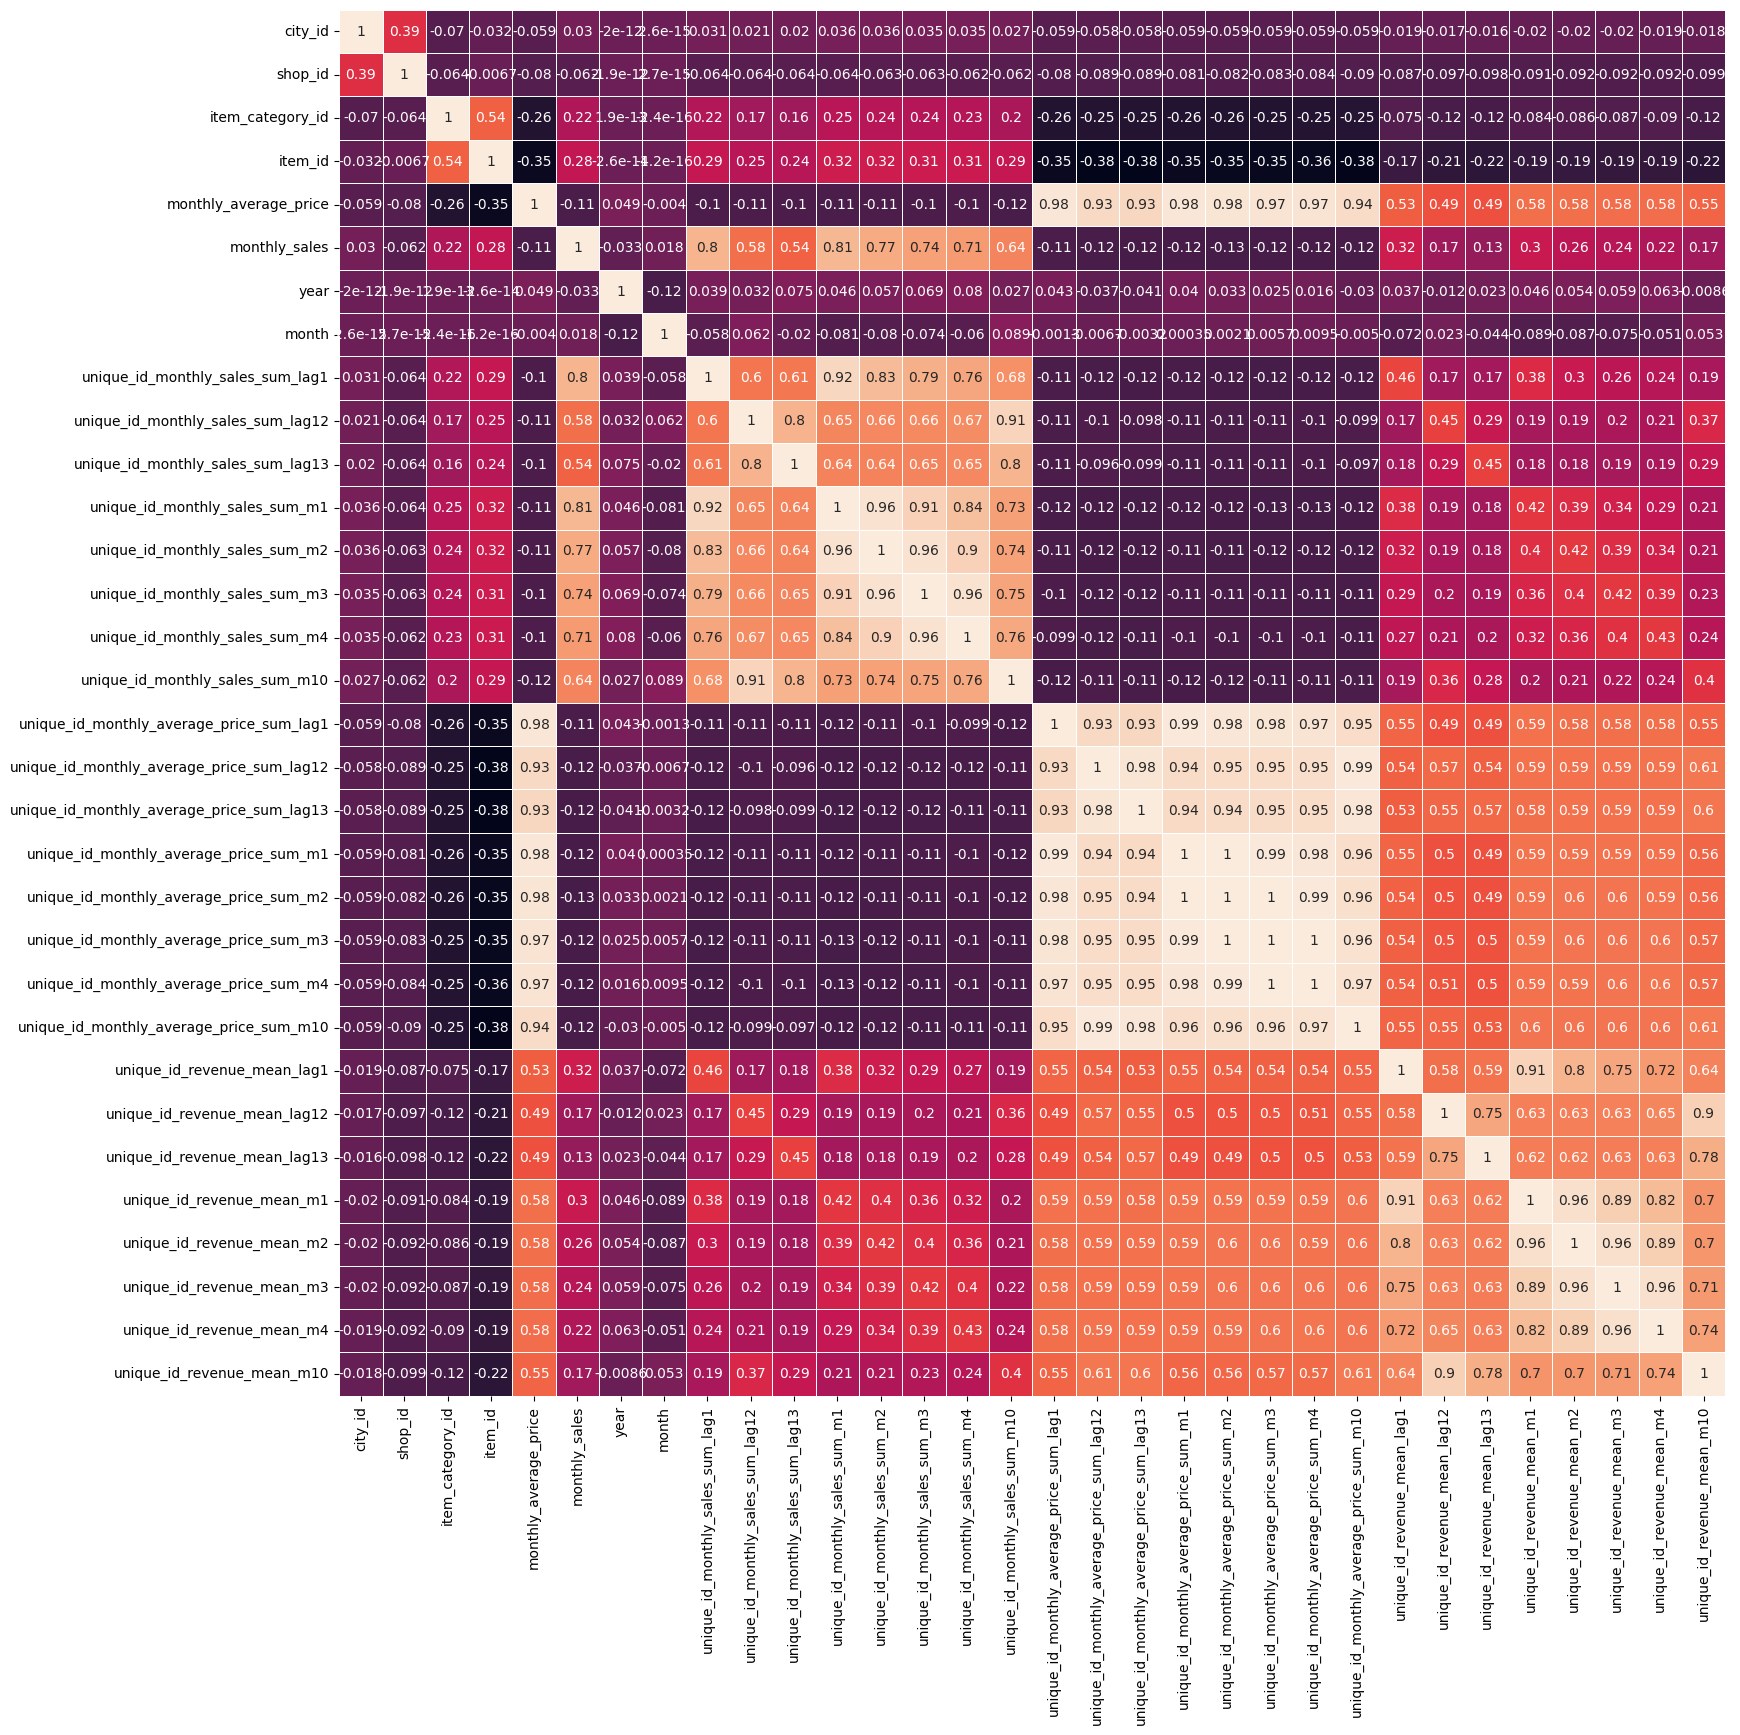

In [88]:
plt.figure(figsize=(30,18))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True,fmt='.2g',linewidth=.5,cbar=False,square=True)
plt.show()

# TRAIN, VALIDATION, TEST KAGGLE

In [89]:
train_index = sorted(list(df['date'].unique()))[:-2]
valida_index = [sorted(list(df['date'].unique()))[-2]]
test_index = [sorted(list(df['date'].unique()))[-1]]

In [90]:
print(f'Nuestro train index es {train_index}')
print(f'Nuestro valida index es {valida_index}')
print(f'Nuestro test index es {test_index}')

Nuestro train index es [numpy.datetime64('2013-01-31T00:00:00.000000000'), numpy.datetime64('2013-02-28T00:00:00.000000000'), numpy.datetime64('2013-03-31T00:00:00.000000000'), numpy.datetime64('2013-04-30T00:00:00.000000000'), numpy.datetime64('2013-05-31T00:00:00.000000000'), numpy.datetime64('2013-06-30T00:00:00.000000000'), numpy.datetime64('2013-07-31T00:00:00.000000000'), numpy.datetime64('2013-08-31T00:00:00.000000000'), numpy.datetime64('2013-09-30T00:00:00.000000000'), numpy.datetime64('2013-10-31T00:00:00.000000000'), numpy.datetime64('2013-11-30T00:00:00.000000000'), numpy.datetime64('2013-12-31T00:00:00.000000000'), numpy.datetime64('2014-01-31T00:00:00.000000000'), numpy.datetime64('2014-02-28T00:00:00.000000000'), numpy.datetime64('2014-03-31T00:00:00.000000000'), numpy.datetime64('2014-04-30T00:00:00.000000000'), numpy.datetime64('2014-05-31T00:00:00.000000000'), numpy.datetime64('2014-06-30T00:00:00.000000000'), numpy.datetime64('2014-07-31T00:00:00.000000000'), numpy.d

In [91]:
X_train = df[df['date'].isin(train_index)].drop(['monthly_sales','date'],axis=1)
Y_train = df[df['date'].isin(train_index)]['monthly_sales']

X_valida = df[df['date'].isin(valida_index)].drop(['monthly_sales','date'],axis=1)
Y_valida = df[df['date'].isin(valida_index)]['monthly_sales']

X_test = df[df['date'].isin(test_index)].drop(['monthly_sales','date'],axis=1)
Y_test = df[df['date'].isin(test_index)]['monthly_sales']

In [92]:
X_train

,city_id,shop_id,item_category_id,item_id,monthly_average_price,year,month,unique_id_monthly_sales_sum_lag1,unique_id_monthly_sales_sum_lag12,unique_id_monthly_sales_sum_lag13,...,unique_id_monthly_average_price_sum_m4,unique_id_monthly_average_price_sum_m10,unique_id_revenue_mean_lag1,unique_id_revenue_mean_lag12,unique_id_revenue_mean_lag13,unique_id_revenue_mean_m1,unique_id_revenue_mean_m2,unique_id_revenue_mean_m3,unique_id_revenue_mean_m4,unique_id_revenue_mean_m10
unique_id,,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,2013,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1533.125000,2013,2,30.0,NaN,NaN,...,NaN,NaN,45345.378788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,3252.470238,2013,3,27.0,NaN,NaN,...,NaN,NaN,41394.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1590.515152,2013,4,30.0,NaN,NaN,...,NaN,NaN,97574.107143,NaN,NaN,61437.953644,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1447.531250,2013,5,27.0,NaN,NaN,...,NaN,NaN,42943.909091,NaN,NaN,60637.463745,61437.953644,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7_7893,21,7,6,7893,2890.000000,2015,4,4.0,4.0,2.0,...,2140.793651,1812.172222,11826.666667,7559.4000,3980.0,7362.222222,8963.333333,11020.000000,8926.666667,4873.133333
7_7893,21,7,6,7893,2840.000000,2015,5,2.0,3.0,4.0,...,2332.460317,1778.888889,5780.000000,5270.0000,7559.4,5868.888889,7362.222222,8963.333333,11020.000000,2950.000000
7_7893,21,7,6,7893,2490.000000,2015,6,3.0,1.0,3.0,...,2632.460317,1789.979167,8520.000000,1790.0000,5270.0,8708.888889,5868.888889,7362.222222,8963.333333,4176.562500


In [93]:
imputer = KNNImputer()

In [94]:
X_train = imputer.fit_transform(X_train)

In [95]:
Y_train

unique_id
12_11365    30.0
12_11365    27.0
12_11365    30.0
12_11365    27.0
12_11365    30.0
            ... 
7_7893       2.0
7_7893       3.0
7_7893       1.0
7_7893       1.0
7_7893       1.0
Name: monthly_sales, Length: 13632, dtype: float64

In [96]:
X_train

,city_id,shop_id,item_category_id,item_id,monthly_average_price,year,month,unique_id_monthly_sales_sum_lag1,unique_id_monthly_sales_sum_lag12,unique_id_monthly_sales_sum_lag13,...,unique_id_monthly_average_price_sum_m4,unique_id_monthly_average_price_sum_m10,unique_id_revenue_mean_lag1,unique_id_revenue_mean_lag12,unique_id_revenue_mean_lag13,unique_id_revenue_mean_m1,unique_id_revenue_mean_m2,unique_id_revenue_mean_m3,unique_id_revenue_mean_m4,unique_id_revenue_mean_m10
unique_id,,,,,,,,,,,,,,,,,,,,,
12_11365,16.0,12.0,9.0,11365.0,1511.512626,2013.0,1.0,24.8,28.0,29.0,...,1747.729891,2097.979559,35993.718632,39327.462144,41944.888316,50955.509188,60107.980318,44082.509536,40119.475135,53553.816127
12_11365,16.0,12.0,9.0,11365.0,1533.125000,2013.0,2.0,30.0,9.4,6.6,...,1180.068567,1720.168236,45345.378788,16221.627760,15545.485714,59017.304775,56949.762123,43853.949952,26588.972961,14657.413015
12_11365,16.0,12.0,9.0,11365.0,3252.470238,2013.0,3.0,27.0,21.6,13.4,...,1175.612287,1417.326120,41394.375000,28669.454514,18225.056030,41145.851587,37950.570434,32214.449443,21461.035283,29597.850266
12_11365,16.0,12.0,9.0,11365.0,1590.515152,2013.0,4.0,30.0,19.6,17.8,...,3032.180423,2730.216964,97574.107143,54560.523529,49037.628571,61437.953644,50883.383385,49597.469935,47464.088889,52010.071429
12_11365,16.0,12.0,9.0,11365.0,1447.531250,2013.0,5.0,27.0,11.0,16.6,...,2116.224230,2635.474603,42943.909091,30805.300000,44788.600000,60637.463745,61437.953644,49403.072237,37156.476632,29426.439683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7_7893,21.0,7.0,6.0,7893.0,2890.000000,2015.0,4.0,4.0,4.0,2.0,...,2140.793651,1812.172222,11826.666667,7559.400000,3980.000000,7362.222222,8963.333333,11020.000000,8926.666667,4873.133333
7_7893,21.0,7.0,6.0,7893.0,2840.000000,2015.0,5.0,2.0,3.0,4.0,...,2332.460317,1778.888889,5780.000000,5270.000000,7559.400000,5868.888889,7362.222222,8963.333333,11020.000000,2950.000000
7_7893,21.0,7.0,6.0,7893.0,2490.000000,2015.0,6.0,3.0,1.0,3.0,...,2632.460317,1789.979167,8520.000000,1790.000000,5270.000000,8708.888889,5868.888889,7362.222222,8963.333333,4176.562500


# Model Train

In [97]:
model = xgb.XGBRegressor(eval_metric = "rmse", seed = 175,learning_rate =0.1)

# RMSE EVALUATION

In [98]:
model.fit(
    X_train,Y_train,
    eval_set = [(X_train,Y_train), (X_valida,Y_valida)],
    verbose = True,
)

[0]	validation_0-rmse:7.33861	validation_1-rmse:6.91649
[1]	validation_0-rmse:6.83173	validation_1-rmse:6.37241
[2]	validation_0-rmse:6.39090	validation_1-rmse:5.89450
[3]	validation_0-rmse:6.00352	validation_1-rmse:5.47146
[4]	validation_0-rmse:5.66346	validation_1-rmse:5.10418
[5]	validation_0-rmse:5.36936	validation_1-rmse:4.78530
[6]	validation_0-rmse:5.11469	validation_1-rmse:4.50139
[7]	validation_0-rmse:4.89089	validation_1-rmse:4.25779
[8]	validation_0-rmse:4.69704	validation_1-rmse:4.06016
[9]	validation_0-rmse:4.53384	validation_1-rmse:3.89371
[10]	validation_0-rmse:4.39219	validation_1-rmse:3.74291
[11]	validation_0-rmse:4.27488	validation_1-rmse:3.62222
[12]	validation_0-rmse:4.16060	validation_1-rmse:3.51076
[13]	validation_0-rmse:4.06947	validation_1-rmse:3.42934
[14]	validation_0-rmse:3.99004	validation_1-rmse:3.35668
[15]	validation_0-rmse:3.92137	validation_1-rmse:3.28799
[16]	validation_0-rmse:3.85918	validation_1-rmse:3.24147
[17]	validation_0-rmse:3.80460	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Model Evaluation

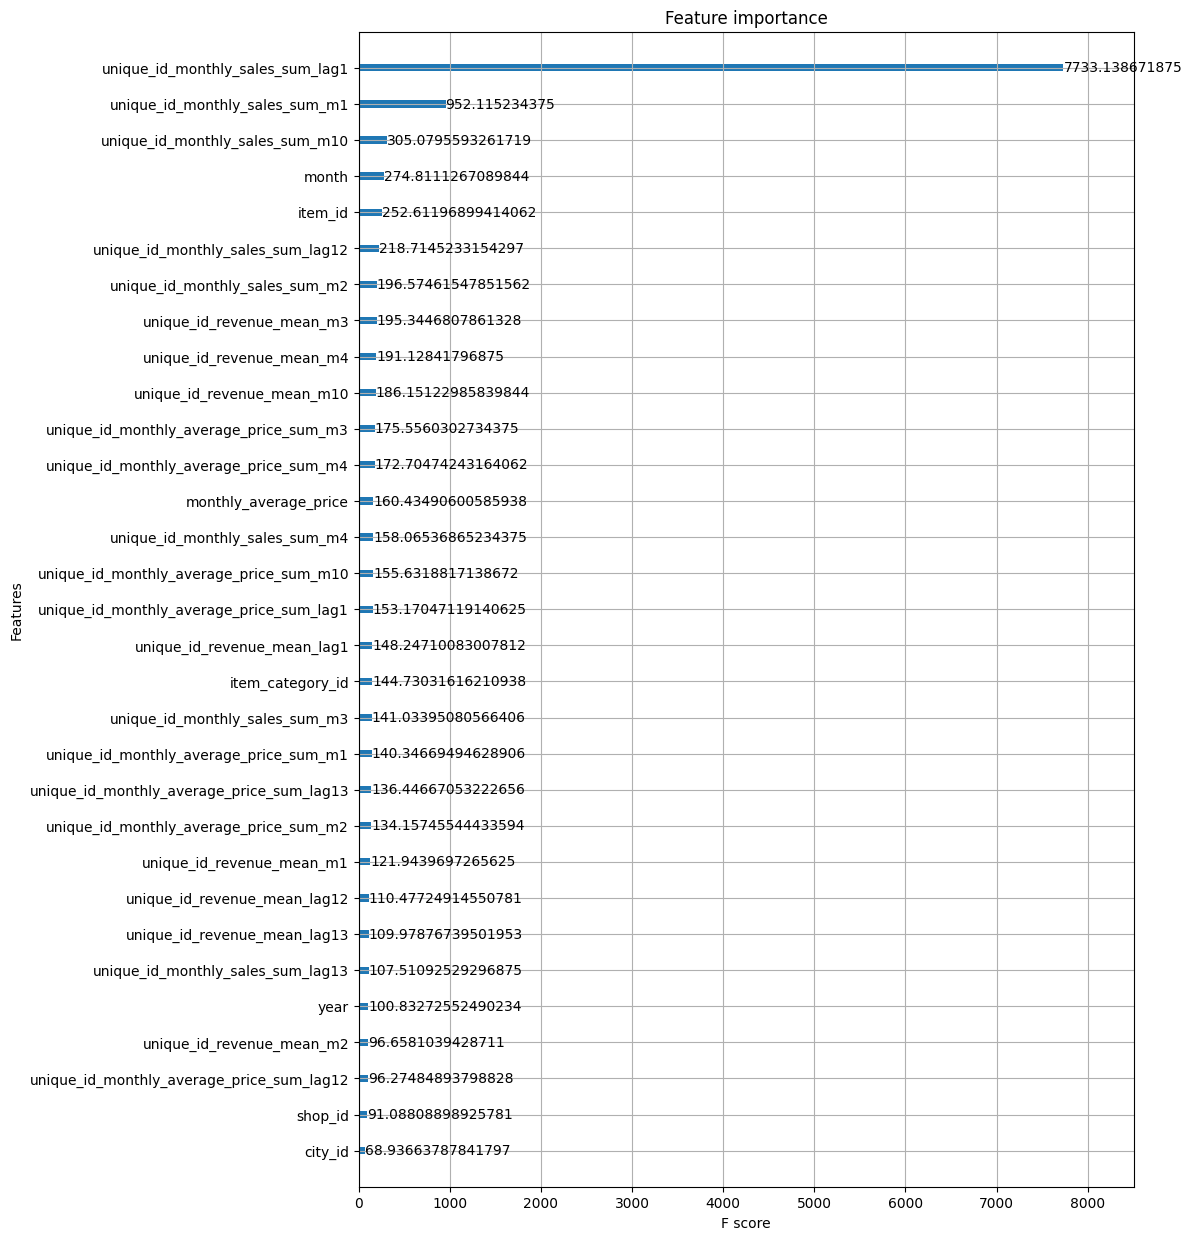

In [99]:
importance = model.get_booster().get_score(importance_type = 'gain')
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10,15))
xgb.plot_importance(model, importance_type = 'gain', ax = ax);

## Prediction

In [100]:
X_test

,city_id,shop_id,item_category_id,item_id,monthly_average_price,year,month,unique_id_monthly_sales_sum_lag1,unique_id_monthly_sales_sum_lag12,unique_id_monthly_sales_sum_lag13,...,unique_id_monthly_average_price_sum_m4,unique_id_monthly_average_price_sum_m10,unique_id_revenue_mean_lag1,unique_id_revenue_mean_lag12,unique_id_revenue_mean_lag13,unique_id_revenue_mean_m1,unique_id_revenue_mean_m2,unique_id_revenue_mean_m3,unique_id_revenue_mean_m4,unique_id_revenue_mean_m10
unique_id,,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,995.680556,2015,10,21.0,6.0,15.0,...,957.900312,892.751305,20909.291667,5170.000000,14426.785714,17352.359127,14179.581349,13428.187661,22178.578818,19889.205808
12_11369,16,12,9,11369,1321.367605,2015,10,30.0,30.0,30.0,...,899.070439,862.270456,39641.028139,38403.809524,31827.532680,28615.068110,28474.204563,27524.404811,26972.113183,25868.113692
12_11370,16,12,9,11370,681.715341,2015,10,30.0,30.0,30.0,...,514.813982,441.265727,20451.460229,16895.437292,29644.096483,18435.188791,17115.029951,13951.474333,15444.419448,13237.971801
12_11373,16,12,9,11373,437.929115,2015,10,30.0,30.0,30.0,...,315.604498,334.374572,13137.873461,11580.444444,11944.624402,12319.358127,10484.529511,8738.636191,9468.134926,10031.237155
12_12231,16,12,49,12231,350.000000,2015,10,2.0,5.0,3.0,...,350.000000,350.000000,700.000000,1750.000000,1050.000000,583.333333,816.666667,700.000000,700.000000,1166.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7_5822,21,7,35,5822,1149.000000,2015,10,7.0,4.0,10.0,...,1149.000000,1049.000000,8043.000000,4196.000000,10490.000000,6894.000000,8043.000000,8043.000000,10341.000000,9441.000000
7_6185,21,7,30,6185,499.000000,2015,10,2.0,3.0,1.0,...,499.000000,499.000000,998.000000,1497.000000,499.000000,997.833333,1164.166667,665.333333,665.333333,1663.333333
7_6497,21,7,28,6497,749.000000,2015,10,1.0,7.0,2.0,...,1299.133333,799.000000,749.000000,5593.000000,1798.000000,3080.430556,4629.563889,2798.133333,3797.466667,6125.666667


In [101]:
if 'monthly_sales' in X_test.columns:
  X_test.drop('monthly_sales', axis = 1, inplace = True)

In [102]:
Y_test_predict = pd.DataFrame(model.predict(X_test),columns = ['Prediction'],index = X_test.index)
X_test['monthly_sales'] = Y_test_predict

In [103]:
Y_test_predict

,Prediction
unique_id,
12_11365,17.567707
12_11369,25.808550
12_11370,29.951260
12_11373,29.722309
12_12231,2.235151
...,...
7_5822,7.723884
7_6185,2.300701
7_6497,4.054706


In [104]:
X_test.reset_index(inplace=True)

In [105]:
X_test.head(5)

,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,year,month,unique_id_monthly_sales_sum_lag1,unique_id_monthly_sales_sum_lag12,...,unique_id_monthly_average_price_sum_m10,unique_id_revenue_mean_lag1,unique_id_revenue_mean_lag12,unique_id_revenue_mean_lag13,unique_id_revenue_mean_m1,unique_id_revenue_mean_m2,unique_id_revenue_mean_m3,unique_id_revenue_mean_m4,unique_id_revenue_mean_m10,monthly_sales
0,12_11365,16,12,9,11365,995.680556,2015,10,21.0,6.0,...,892.751305,20909.291667,5170.000000,14426.785714,17352.359127,14179.581349,13428.187661,22178.578818,19889.205808,17.567707
1,12_11369,16,12,9,11369,1321.367605,2015,10,30.0,30.0,...,862.270456,39641.028139,38403.809524,31827.532680,28615.068110,28474.204563,27524.404811,26972.113183,25868.113692,25.808550
2,12_11370,16,12,9,11370,681.715341,2015,10,30.0,30.0,...,441.265727,20451.460229,16895.437292,29644.096483,18435.188791,17115.029951,13951.474333,15444.419448,13237.971801,29.951260
3,12_11373,16,12,9,11373,437.929115,2015,10,30.0,30.0,...,334.374572,13137.873461,11580.444444,11944.624402,12319.358127,10484.529511,8738.636191,9468.134926,10031.237155,29.722309
4,12_12231,16,12,49,12231,350.000000,2015,10,2.0,5.0,...,350.000000,700.000000,1750.000000,1050.000000,583.333333,816.666667,700.000000,700.000000,1166.666667,2.235151


In [106]:
Y_valida_prueba = pd.DataFrame(Y_valida)

In [107]:
Y_TEST_PRUEBA = X_test.copy()
Y_TEST_PRUEBA.drop('monthly_sales',axis=1,inplace = True)
Y_TEST_PRUEBA = pd.merge(Y_TEST_PRUEBA, Y_valida_prueba, on = ['unique_id'], how = 'left')
# Y_TEST_PRUEBA

In [108]:
# Y_test_predict

In [109]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)


rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train = str(round(rmse_train,3)).replace('.','_')
rmse_valida = str(round(rmse_valida,3)).replace('.','_')

In [110]:
df_sin_octubre = df_final[df_final['date']!='2015-10-31']
df_predict = pd.concat([df_sin_octubre, X_test[['unique_id','city_id','shop_id','item_category_id','item_id','monthly_average_price','monthly_sales']]],axis=0)
# df_predict

In [111]:
df_sin_octubre = df_final[df_final['date']!='2015-10-31']
df_test_prueba = pd.concat([df_sin_octubre, Y_TEST_PRUEBA[['unique_id','city_id','shop_id','item_category_id','item_id','monthly_average_price','monthly_sales']]],axis=0)
# df_test_prueba

In [112]:
# Y_valida_predict

In [113]:
df_predict['date'].fillna('2015-10-31',inplace=True)

In [114]:
df_test_prueba['date'].fillna('2015-10-31',inplace=True)

In [115]:
x = df_predict.set_index('date').resample('M')['monthly_sales'].sum()

In [116]:
t = df_test_prueba.set_index('date').resample('M')['monthly_sales'].sum()

# COMPROBACIONES GRÁFICAS

In [117]:
###### comprobar como se equivoca mi modelo ######
results_df = Y_valida_prueba.join(Y_test_predict)
results_df['diff'] = results_df['Prediction']-results_df['monthly_sales']
results_df.sort_values(by='diff',ascending=False)

,monthly_sales,Prediction,diff
unique_id,,,
24_2308,1.0,7.970004,6.970004
35_17717,12.0,18.776314,6.776314
7_17717,16.0,22.644978,6.644978
15_5822,5.0,11.556165,6.556165
59_20949,18.0,23.894558,5.894558
...,...,...,...
31_15256,12.0,6.555214,-5.444786
31_5822,29.0,22.290266,-6.709734
6_5822,21.0,13.974070,-7.025930


In [118]:
df.T

unique_id,12_11365,12_11365,12_11365,12_11365,12_11365,12_11365,12_11365,12_11365,12_11365,12_11365,...,7_7893,7_7893,7_7893,7_7893,7_7893,7_7893,7_7893,7_7893,7_7893,7_7893
date,2013-01-31 00:00:00,2013-02-28 00:00:00,2013-03-31 00:00:00,2013-04-30 00:00:00,2013-05-31 00:00:00,2013-06-30 00:00:00,2013-07-31 00:00:00,2013-08-31 00:00:00,2013-09-30 00:00:00,2013-10-31 00:00:00,...,2015-01-31 00:00:00,2015-02-28 00:00:00,2015-03-31 00:00:00,2015-04-30 00:00:00,2015-05-31 00:00:00,2015-06-30 00:00:00,2015-07-31 00:00:00,2015-08-31 00:00:00,2015-09-30 00:00:00,2015-10-31 00:00:00
city_id,16,16,16,16,16,16,16,16,16,16,...,21,21,21,21,21,21,21,21,21,21
shop_id,12,12,12,12,12,12,12,12,12,12,...,7,7,7,7,7,7,7,7,7,7
item_category_id,9,9,9,9,9,9,9,9,9,9,...,6,6,6,6,6,6,6,6,6,6
item_id,11365,11365,11365,11365,11365,11365,11365,11365,11365,11365,...,7893,7893,7893,7893,7893,7893,7893,7893,7893,7893
monthly_average_price,1511.512626,1533.125,3252.470238,1590.515152,1447.53125,1302.34375,1736.785714,3072.361111,9305.121212,2493.11336,...,2565.0,2956.666667,2956.666667,2890.0,2840.0,2490.0,2690.0,2490.0,2689.9,2689.9
monthly_sales,30.0,27.0,30.0,27.0,30.0,28.0,20.0,16.0,24.0,30.0,...,4.0,0.0,4.0,2.0,3.0,1.0,1.0,1.0,5.0,0.0
year,2013,2013,2013,2013,2013,2013,2013,2013,2013,2013,...,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015
month,1,2,3,4,5,6,7,8,9,10,...,1,2,3,4,5,6,7,8,9,10
unique_id_monthly_sales_sum_lag1,NaN,30.0,27.0,30.0,27.0,30.0,28.0,20.0,16.0,24.0,...,7.0,4.0,0.0,4.0,2.0,3.0,1.0,1.0,1.0,5.0


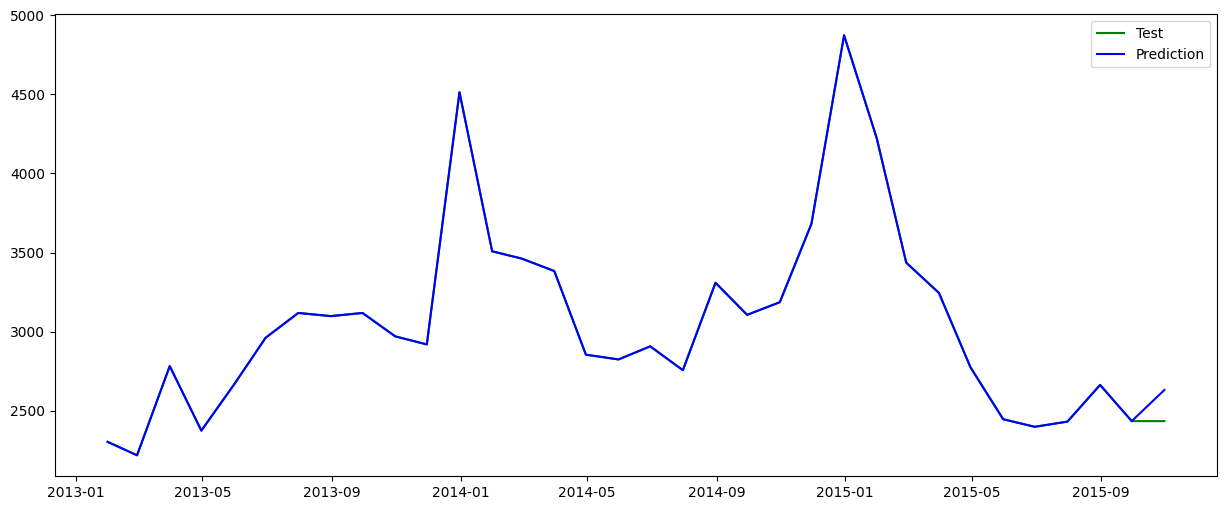

In [119]:
plt.figure(figsize=(15,6))

plt.plot(t, color = 'g', label = 'Test')
plt.plot(x, color = 'b', label='Prediction')

#### Incluir leyenda ####
plt.legend(loc='best')

#### Mostrar la figura ####
plt.show()

In [120]:
print(f'Train RMSE: {rmse_train}')
print(f'Validation RMSE: {rmse_valida}')

Train RMSE: 2_787
Validation RMSE: 2_984


# Export data

In [121]:
f'submission_train_{rmse_train}_valida{rmse_valida}.csv'

'submission_train_2_787_valida2_984.csv'

In [122]:
(
    X_test[['unique_id','monthly_sales']]
    .to_csv(f'submission_train_{rmse_train}_valida{rmse_valida}.csv',index = False)
)

In [123]:
float(rmse_train)-float(rmse_valida)

-197.0